In [15]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.data'
df = pd.read_csv(url, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0).values

X_train, X_valid = train_test_split(ratings_matrix, test_size=0.2)

In [19]:
class FISM(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super().__init__()
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        self.query_embeddings = nn.Embedding(num_items, embedding_dim)
        self.target_embeddings = nn.Embedding(num_items, embedding_dim)

    def forward(self, user, item_i, item_j, batch_score, n):
        user_bias = self.user_bias(user)
        item_bias = self.item_bias(item_i)

        query_emb = self.query_embeddings(item_j)
        target_emb = self.target_embeddings(item_i).unsqueeze(2)
        batch_score = batch_score.unsqueeze(1)

        sim_mat = torch.bmm(query_emb, target_emb)
        pred = torch.bmm(batch_score, sim_mat).squeeze(-1) / (n - 1)
        pred += self.global_bias + user_bias + item_bias
        return pred.squeeze(-1)

In [20]:
class FISM_simple(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super().__init__()
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)

    def forward(self, user, item_i, item_j, batch_score, n):
        user_bias = self.user_bias(user)
        item_bias = self.item_bias(item_i)

        query_emb = self.item_embeddings(item_j)
        target_emb = self.item_embeddings(item_i).unsqueeze(2)
        batch_score = batch_score.unsqueeze(1)

        sim_mat = torch.bmm(query_emb, target_emb)
        pred = torch.bmm(batch_score, sim_mat).squeeze(-1) / (n - 1)
        pred += self.global_bias + user_bias + item_bias
        return pred.squeeze(-1)

In [21]:
def convert_data_to_model_input(X):
    for user_idx, row in enumerate(X):
        nonzero_idx = np.nonzero(row)[0]
        nonzero = torch.tensor(row[nonzero_idx], dtype=torch.float32, device=device)
        n = len(nonzero_idx)

        if n <= 1:
            continue

        batch_i = []
        batch_j = []
        batch_score = []
        for item_idx in range(n):
            target_idx = nonzero_idx[item_idx]
            other_idxs = nonzero_idx[:item_idx].tolist() + nonzero_idx[item_idx+1:].tolist()
            batch_i.append(target_idx)
            batch_j.append(other_idxs)
            batch_score.append(row[other_idxs])

        user_idx = torch.tensor([user_idx] * n, device=device)
        batch_i = torch.tensor(batch_i, device=device)
        batch_j = torch.tensor(batch_j, device=device)
        batch_score = torch.tensor(np.array(batch_score), dtype=torch.float32, device=device)

        yield user_idx, batch_i, batch_j, batch_score, n, nonzero

In [41]:
def train(n_epoch, model, optimizer, loss_fn, device):
    model.to(device)
    train_history = []
    valid_history = []

    for epoch in range(n_epoch):
        total_train_loss = 0
        train_n = 0
        total_valid_loss = 0
        valid_n = 0

        model.train()
        for user_idx, batch_i, batch_j, batch_score, n, nonzero in convert_data_to_model_input(X_train):
            optimizer.zero_grad()
            pred = model.forward(user_idx, batch_i, batch_j, batch_score, n)
            loss = loss_fn(pred, nonzero)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * n
            train_n += n

        train_history.append(total_train_loss / train_n)
        print(f"Epoch {epoch + 1}, Train loss: {total_train_loss / train_n}, ", end="")

        model.eval()
        with torch.no_grad():
            for user_idx, batch_i, batch_j, batch_score, n, nonzero in convert_data_to_model_input(X_valid):
                pred = model.forward(user_idx, batch_i, batch_j, batch_score, n)
                loss = loss_fn(pred, nonzero)

                total_valid_loss  += loss.item() * n
                valid_n += n

        valid_history.append(total_valid_loss / valid_n)
        print(f"Valid loss: {total_valid_loss / valid_n}")

    return train_history, valid_history

In [42]:
n_users, n_items = ratings_matrix.shape
fism = FISM(n_users, n_items, 20)
optimizer = optim.Adam(fism.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

fism_loss = train(30, fism, optimizer, loss_fn, device)

Epoch 1, Train loss: 15.744496623730631, Valid loss: 12.058922373768446
Epoch 2, Train loss: 10.070586490459867, Valid loss: 7.98548735552684
Epoch 3, Train loss: 6.767456026403803, Valid loss: 5.809680419514538
Epoch 4, Train loss: 5.013967150867144, Valid loss: 4.724769275013148
Epoch 5, Train loss: 4.069923787617136, Valid loss: 4.139081551670006
Epoch 6, Train loss: 3.502634998805958, Valid loss: 3.7781417839370413
Epoch 7, Train loss: 3.1182495555518384, Valid loss: 3.5271714125648352
Epoch 8, Train loss: 2.832573752579368, Valid loss: 3.336919636917164
Epoch 9, Train loss: 2.6067657572567247, Valid loss: 3.1846459563969636
Epoch 10, Train loss: 2.4208955485070427, Valid loss: 3.058491976585101
Epoch 11, Train loss: 2.2635038648992936, Valid loss: 2.951565488439685
Epoch 12, Train loss: 2.127327861785003, Valid loss: 2.859359485931476
Epoch 13, Train loss: 2.0074560340894103, Valid loss: 2.7789506180436927
Epoch 14, Train loss: 1.9004203684724423, Valid loss: 2.708218483687624
Epo

In [43]:
n_users, n_items = ratings_matrix.shape
fism_simple = FISM_simple(n_users, n_items, 20)
optimizer = optim.Adam(fism_simple.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

fism_simple_loss = train(30, fism_simple, optimizer, loss_fn, device)

Epoch 1, Train loss: 14.341536665061673, Valid loss: 11.04100206458869
Epoch 2, Train loss: 8.984909456561988, Valid loss: 7.401187646701819
Epoch 3, Train loss: 6.181017634859912, Valid loss: 5.547215452191736
Epoch 4, Train loss: 4.70802078474698, Valid loss: 4.568255728280337
Epoch 5, Train loss: 3.8899026724039074, Valid loss: 4.015206680758707
Epoch 6, Train loss: 3.3970434240996377, Valid loss: 3.671331493165097
Epoch 7, Train loss: 3.0711466937410257, Valid loss: 3.4345467837886954
Epoch 8, Train loss: 2.836062144303896, Valid loss: 3.2564677655588468
Epoch 9, Train loss: 2.654143690654024, Valid loss: 3.1132288813002544
Epoch 10, Train loss: 2.5058648554882126, Valid loss: 2.9924056757329565
Epoch 11, Train loss: 2.38047766582891, Valid loss: 2.887227878511091
Epoch 12, Train loss: 2.271676319737559, Valid loss: 2.7938012992291985
Epoch 13, Train loss: 2.1755098341854797, Valid loss: 2.7097222460248496
Epoch 14, Train loss: 2.0893413157833893, Valid loss: 2.633411885196743
Epoc

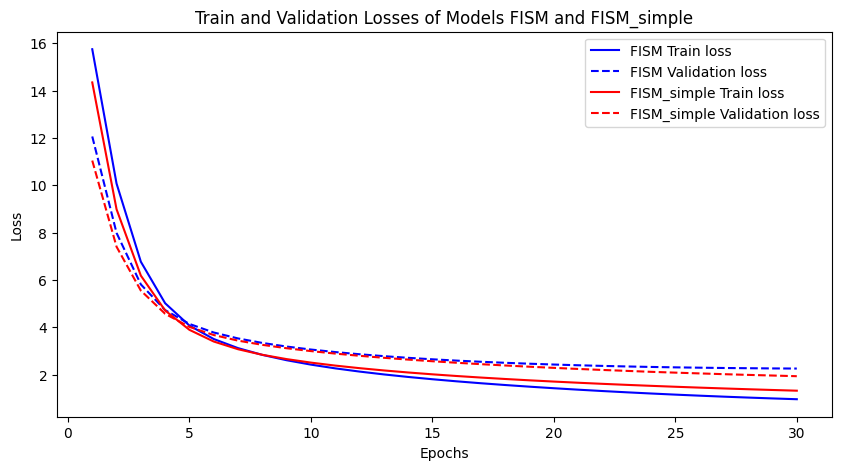

In [45]:
import matplotlib.pyplot as plt

def plot_losses(train_losses_a, valid_losses_a, train_losses_b, valid_losses_b):
    epochs = range(1, len(train_losses_a) + 1)

    plt.figure(figsize=(10, 5))

    plt.plot(epochs, train_losses_a, 'b', label='FISM Train loss')
    plt.plot(epochs, valid_losses_a, 'b--', label='FISM Validation loss')

    plt.plot(epochs, train_losses_b, 'r', label='FISM_simple Train loss')
    plt.plot(epochs, valid_losses_b, 'r--', label='FISM_simple Validation loss')

    plt.title('Train and Validation Losses of Models FISM and FISM_simple')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_losses(fism_loss[0], fism_loss[1], fism_simple_loss[0], fism_simple_loss[1])